# Предобработка текстов на русском языке. Извлечение ключевых слов и словосочетаний

## Предобработка текстов на русском языке
Для начала рассматриваем некоторое количество новостных сообщений, опубликованных в январе-феврале 2016 года, которые находятся в файле 'texts.json'. Мы считаем, что принципиальных различий между текстами нет, поэтому склеиваем их в один большой текст. 

In [3]:
%matplotlib inline
import json

infile = '../data/texts.json'


with open(infile) as data_file:    
    data = json.load(data_file)
collection = []
for i in data['data']:
    collection.append(i['text'])
print 'N of texts', len(collection)
merged_text = ' '.join(collection)

N of texts 221


Используем самый простой токенизатор из NLTK, который разбивает тексты на токены по пробелам. Удаляем символы пунктуаци, цифры и несколько разных видов тире. Приводим текст к нижнему регистру – на этом стандартная и минимальная обработка текста заканчивается.

In [21]:
import nltk
from nltk.tokenize import WhitespaceTokenizer
from string import punctuation
exclude = set(punctuation + '0123456789'+u'–—'+u'«»')
merged_text = ''.join(ch for ch in merged_text if ch not in exclude)
tokens = WhitespaceTokenizer().tokenize(merged_text.lower())
for i in tokens[:10]: print i

как
вам
удалось
дать
настолько
точный
прогноз
у
меня
же


In [4]:
print punctuation

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


Токен – словоупотребление (слово + его место в тексте), тип – словоформа. Чтобы посчитать количество типов в тексте используем частотные словари NLTK.

In [5]:
print 'N of tokens: ', len(tokens)
types = nltk.FreqDist(tokens)
print 'N of types:', len(types)
print types

N of tokens:  148112
N of types: 28570
<FreqDist with 28570 samples and 148112 outcomes>


In [48]:
for i in types.most_common(20):
     print i[0], i[1]

в 6100
и 3732
на 3342
не 2026
что 1686
по 1676
с 1505
за 963
это 781
года 777
к 743
а 729
для 707
как 625
от 598
до 593
но 585
о 545
из 541
году 531


Построим кривую Ципфа для текста и убедимся, что она выглядит правильно.

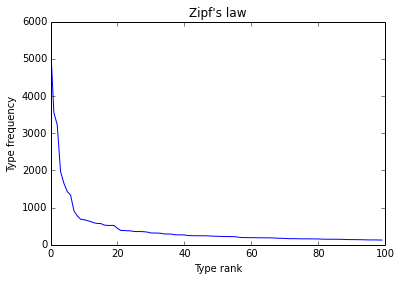

In [5]:
import matplotlib.pyplot as plt
fr = types.values()
fr.sort(reverse=True)
plt.plot(fr[:100])
plt.ylabel('Type frequency')
plt.xlabel('Type rank')
plt.title("Zipf's law")
plt.show()

Лемматризируем каждое слово с помощью PyMorphy2 и создаем частотный словарь лемм. 

In [9]:
import pymorphy2
morph = pymorphy2.MorphAnalyzer()
lemmata = nltk.FreqDist()
for t in types:
    try:
        l = morph.parse(t)[0].normal_form
        if l in lemmata:
            lemmata[l] += types[t]
        else:
            lemmata[l] = types[t]
    except IndexError:
        if t in lemmata:
            lemmata[t] += types[t]
        else:
            lemmata[t] = types[t]
print 'N of lemmata:', len(lemmata)
for i in lemmata.most_common(20):
    print i[0], i[1]

N of lemmata: 14789
в 6188
и 3726
на 3342
не 2026
год 1740
что 1723
по 1675
с 1645
это 1372
быть 1359
за 962
рубль 929
который 795
к 750
а 726
тот 715
для 706
о 703
он 683
цена 635


Но разве все слова нам нужны? Не нужны нам стоп-слова: предлоги, местоимения, союзы и кое-что еще. 

In [12]:
from nltk.corpus import stopwords
for i in stopwords.words('russian'):
    print i,
mystopwords = stopwords.words('russian')+[u'это', u'иза', u'свой',u'млрд', u'млн',u'млна',u'тыс',u'трлн']

и в во не что он на я с со как а то все она так его но да ты к у же вы за бы по только ее мне было вот от меня еще нет о из ему теперь когда даже ну вдруг ли если уже или ни быть был него до вас нибудь опять уж вам ведь там потом себя ничего ей может они тут где есть надо ней для мы тебя их чем была сам чтоб без будто чего раз тоже себе под будет ж тогда кто этот того потому этого какой совсем ним здесь этом один почти мой тем чтобы нее сейчас были куда зачем всех никогда можно при наконец два об другой хоть после над больше тот через эти нас про всего них какая много разве три эту моя впрочем хорошо свою этой перед иногда лучше чуть том нельзя такой им более всегда конечно всю между


Создаем список лемм без стоп слов и снова обновляем частотный словарь.

In [8]:
lemmata_no_sw = nltk.FreqDist()
for l in lemmata:
    if not l in mystopwords:
        lemmata_no_sw[l] = lemmata[l]
for i in lemmata_no_sw.most_common(20):
    print i[0], i[1]

год 1742
который 766
рубль 758
цена 636
россия 520
весь 500
компания 463
нефть 448
рынок 442
российский 426
страна 425
рост 325
экономика 323
говорить 307
банка 278
ещё 276
также 267
уровень 254
данный 250
мочь 247


А теперь посмотрим только на существительные и подумаем о них как о *ключевых словах*.

In [18]:
nouns = nltk.FreqDist()
for t in types:
    if not t in mystopwords:
        try:
            gram_info = morph.parse(t)[0]
            if 'NOUN' in gram_info.tag:
                l = gram_info.normal_form
                if l in nouns:
                    nouns[l] += types[t]
                else:
                    nouns[l] = types[t]
        except IndexError:
            pass
print 'N of nouns:', len(nouns)
for i in nouns.most_common(20):
    print i[0], i[1]

N of nouns: 6365
год 1742
рубль 758
цена 636
россия 520
компания 463
нефть 448
рынок 442
страна 425
рост 325
экономика 323
банка 278
уровень 254
доллар 242
млна 224
правительство 222
слово 221
бюджет 218
курс 218
цб 218
эксперт 215


## Извлечение ключевых словосочетаний по шаблону

Допустим, что ключевым может быть словосочетание, которое удовлетворяет хорошему грамматическому шаблону, например, СУЩ + СУЩ, ПРИЛ + СУЩ. Попробуем извлечь все такие пары слов из текста. Функция match() принимает на вход n-граму – последовательность из n слов и проверяет ее на соответствие каждому шаблону. 

In [15]:
from itertools import product
patterns = ['ADJF+NOUN','PRTS+NOUN','NOUN+NOUN']
    
def match(ngram, patterns = patterns):
    index = []
    for word in ngram:
        if word in mystopwords:
            return None
        buf = [(p.normal_form, p.tag.POS) for p in morph.parse(word)]
        index.append((word,buf)) 
    pos_tagging = product(*[ind[1] for ind in index])     
    possible_patterns = map(lambda pos_tag: zip(*pos_tag), pos_tagging) 
    possible_patterns = map(lambda pattern: [pattern[0], map(lambda grammeme: grammeme, pattern[1])], possible_patterns)
    possible_patterns = map(lambda pattern: (pattern[0], '+'.join(pattern[1])), possible_patterns)
    for pattern in possible_patterns:
       # print pattern
        if pattern[1] in patterns:
            return pattern

    return None
        

Применяем функцию к тексту. Сразу виден существенный недостаток этой функции – словосочетания несогласованы.

In [24]:
pattern_coll2  = nltk.FreqDist() 
count = 0
coll2 = nltk.FreqDist(nltk.bigrams(tokens))
for c2 in coll2:
    try:
        p = match(c2)
        if p != None:
            collocation = ' '.join(p[0])
            if collocation in pattern_coll2:
                pattern_coll2[collocation] += coll2[c2]
            else:
                pattern_coll2[collocation] = coll2[c2]
    except:
        pass

for c2 in pattern_coll2.most_common(10):
    print c2[0], c2[1]

прошлое год 141
декабрь год 64
саудовский аравия 60
курс рубль 58
январь год 53
рост цена 47
конец год 46
нефтяной цена 46
низкий цена 44
первый очередь 44


Совсем несогласованы.

In [19]:
m = match([u'точный', u'прогноз'])
print m[0][0], m[0][1], m[1]

m = match([u'веселая', u'музыка'])
print m[0][0], m[0][1], m[1]

точный прогноз ADJF+NOUN
весёлый музыка ADJF+NOUN


## Извлечение ключевых словосочетаний по статистическим мерам связности 

Используем реализацию из NLTK:
* генерируем список биграм
* удаляем биграмы, которые встречаются реже 3 раз
* находим 20 биграм с максимальным значением статистического критерия

Используем $t–score$.

In [25]:
from nltk.collocations import *
bigram_measures = nltk.collocations.BigramAssocMeasures()
finder = BigramCollocationFinder.from_words(tokens)
finder.apply_freq_filter(3)
tscore_ranking = finder.nbest(bigram_measures.student_t, 20)
for i in tscore_ranking: print ' '.join(i)

в году
на нефть
при этом
в том
за баррель
в россии
цен на
том что
цены на
то есть
а также
долл за
том числе
по итогам
млрд рублей
за счет
по данным
в этом
прошлого года
может быть


Удалим стоп-слова и повторим все шаги заново. 

In [35]:
finder.apply_word_filter(lambda w: w in mystopwords)
tscore_ranking = finder.nbest(bigram_measures.student_t, 20)
for i in tscore_ranking: print ' '.join(i)

прошлого года
прошлом году
первую очередь
января года
итогам года
таким образом
нефтяных цен
саудовской аравии
см «нг»
декабря года
декабре года
курс рубля
речь идет
курса рубля
точки зрения
владимир путин
саудовская аравия
ближайшее время
экономического роста
низких цен


Используем  $PMI$.

In [39]:
pmi_ranking =  finder.nbest(bigram_measures.pmi, 20)
for i in pmi_ranking: print ' '.join(i)

liqui moly
shanghai composite
«эксон нл»
исламского банкинга
клаус шваб
нижний новгород
ньюйоркская конвенция
парниковых газов
температура кристаллизации
товарных рынков»
wall street
«взлетная полоса»
«экологический менеджмент»
хасан рухани
эммануэль ибе
electric power
iron ore
new york
«сахалин энерджи»
«фридом финанс»


Используем $\chi^2$.

In [36]:
chi2_ranking =  finder.nbest(bigram_measures.chi_sq, 20)
for i in chi2_ranking: print ' '.join(i).encode('utf8')

electric power
forex club
goldman sachs
iron ore
liqui moly
mfx broker
new york
qb finance
shanghai composite
«деловой фарватер»
«сахалин энерджи»
«фридом финанс»
«эксон нл»
«южного потока»
генеральная прокуратура
исламского банкинга
квадратного метра
клаус шваб
кристин лагард
ксения юдаева


Используем $LogLikelihood Ratio$, $LLR$.

In [37]:
llr_ranking = finder.nbest(bigram_measures.likelihood_ratio, 20)
for i in llr_ranking: print ' '.join(i)

прошлого года
первую очередь
прошлом году
саудовской аравии
таким образом
см «нг»
саудовская аравия
точки зрения
речь идет
риа новости
нефтяных цен
сих пор
владимир путин
января года
итогам года
«черного золота»
ближайшее время
любом случае
алексей улюкаев
нефтяных котировок


Сравнение полученных ранжировок можно выаолнить с помощью рангового коэффициента корреляции Спирмена.

Определение (http://www.machinelearning.ru/)

Заданы две выборки $x = (x_1,\ldots,x_n)$, $y = (y_1,\ldots,y_n)$.

Вычисление корреляции Спирмена:

Коэффициент корреляции Спирмена вычисляется по формуле:
$\rho=1-\frac{6}{n(n-1)(n+1)}\sum_{i=1}^n(R_i-S_i)^2$, где $R_i$ - ранг наблюдения $x_i$ в ряду $x$, $S_i$ - ранг наблюдения $y_i$ в ряду $y$.

In [40]:
from nltk.metrics.spearman import *
pmi_ranks =  ranks_from_sequence(pmi_ranking)
tscore_ranks = ranks_from_sequence(tscore_ranking)
print spearman_correlation(pmi_ranks, tscore_ranks)

0.0


In [41]:
llr_ranks =  ranks_from_sequence(llr_ranking)
tscore_ranks = ranks_from_sequence(tscore_ranking)
print spearman_correlation(llr_ranks, tscore_ranks)

0.0791208791209


In [23]:
from nltk.collocations import *
bigram_measures = nltk.collocations.BigramAssocMeasures()
finder = BigramCollocationFinder.from_words(tokens, window_size = 20)
finder.apply_freq_filter(2)

finder.apply_word_filter(lambda w: len(w) < 3 or w.lower() in mystopwords)

tscore_ranking = finder.nbest(bigram_measures.student_t, 20)

for i in tscore_ranking: print ' '.join(i)



долл баррель
прошлого года
нефть баррель
прошлом году
итогам года
рублей рублей
цен нефть
долл долл
руб руб
цены нефть
году году
курс рубля
первую очередь
января года
нефтяных цен
нефть долл
баррель долл
рубля рубля
таким образом
конце года


# Стемминг

In [45]:
from nltk.stem.snowball import RussianStemmer
stemmer = RussianStemmer()
print stemmer.stem(u'оптимизация')

оптимизац


Частотный словарь стемов (псевдооснов):

In [50]:
stems = nltk.FreqDist()
for t in types:
    if not t in mystopwords:
        stem = stemmer.stem(t)
        if stem in stems:
            stems[stem] += types[t]
        else:
            stems[stem] = types[t]
for i in stems.most_common(20):
    print i[0], i[1]

год 1602
котор 795
рубл 759
цен 646
росс 522
банк 478
компан 464
нефт 448
стран 433
российск 426
говор 404
так 353
рост 325
экономик 324
рынк 323
нов 295
такж 267
дан 261
сам 260
сво 247


# Задание 1

Найдите ключевые слова и словосочетания для произвольного текста с использованием грамматических шаблонов и хотя бы одной статистической меры связности. Прокомментируйте полученные результаты.

# Задание 2 

Напишите функцию concord(), которая принимает на вход:
* несогласованное словосочетание
* шаблон словосочетания
и возвращает согласованное словосочетание.

# Задание 3 

Реализуйте TextRank и сравните результаты его применения с результами задания 1.


# Литература

* Manning & Shuetze: Ch. 5 – Collocations

* NLTK Book: Collocations HOWTO http://www.nltk.org/howto/collocations.html

* Е. В. Ягунова, Л. М. Пивоварова,  "От конструкций к коллокациям" – http://webground.su/data/lit/pivovarova_yagunova/Ot_kollokatsiy_k_konstruktsiyam.pdf
